# Quickstart

In this quickstart example, we'll fit `scDiffEq` to the LARRY in vitro hematopoietic differentiation dataset, which uses lineage tracing to track cell fate decisions during differentiation. After fitting a model, we'll visualize the inferred dynamics and generatively simulated developmental trajectories from the model. Finally, we'll project our predicted trajectories back into the original gene space. The LARRY dataset provides scRNA measurements at multiple time points, enabling us to study the temporal dynamics of hematopoietic differentiation. Here, we'll look at granular (`dt=0.1d`) changes in gene expression over real time.

### A note on hardware

Here, we're using an NVIDIA T4 GPU (available for free in Colab). However, this package runs well on Apple Silicon (tested on M1) and cpu. Thanks to the [**LightningAI**](https://lightning.ai/docs) framework on which scDiffeq was built, you don't have to make any adjustments when switching hardware; it will automatically be recongized.

In [1]:
import scdiffeq as sdq

print(sdq.__version__, sdq.__path__)

1.0.0rc0 ['/Users/mvinyard/GitHub/scDiffEq/src/scdiffeq']


## Load data

Here we'll use the LARRY (Lineage tracing on transcriptional landscapes links state to fate during differentiation) in vitro dataset, which combines single-cell RNA sequencing with lineage tracing to study hematopoietic differentiation.

* **Paper**: [Weinreb, et al., *Science*. 2020](https://doi.org/10.1126/science.aaw3381)
* **Dataset**: The LARRY dataset provides comprehensive lineage tracing data for studying cell fate decisions during in vitro hematopoietic differentiation.

In [2]:
adata_ref = sdq.datasets.larry(data_dir="/Users/mvinyard/data/")
adata_ref

scDiffEq [INFO]: Loading data from /Users/mvinyard/data/scdiffeq_data/larry/larry.h5ad


AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes', 'ct_gene_corr', 'ct_correlates'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_scaled', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'

### Preprocessing

In [3]:
import umap

UMAP = umap.UMAP(n_components=2)
adata_ref.obsm["X_umap"] = UMAP.fit_transform(adata_ref.obsm["X_pca"])

Subset for example

In [4]:
nm_clones = adata_ref.uns["fate_counts"][["Monocyte", "Neutrophil"]].dropna().index
adata_ref.obs['nm_clones'] = adata_ref.obs["clone_idx"].isin(nm_clones)
MASK = adata_ref.obs["Cell type annotation"].isin(["Monocyte", "Neutrophil", "Undifferentiated"]) & adata_ref.obs['nm_clones']

adata = adata_ref[MASK].copy()

del adata.obsm['X_clone']
del adata.obsm["cell_fate_df"]

adata.obs.index = adata.obs.reset_index(drop=True).index.astype(str)

## Define the model

Here we'll define the model with `sdq.scDiffEq` - the container class for the algorithm and learned model. Under the hood, the `sdq.scDiffEq` uses three key components:

### Components of the `sdq.scDiffEq` model

1. The `LightningDataModule`. The formatted data
2. The `LightningDiffEq`. The neural differential equation implemented for our specific use-case. There are several of these.
3. The `Trainer`.

Together, these three objects complete the basic circuit of a [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) model training workflow.

The `sdq.scDiffEq` is very customizable. The `LightningDiffEq` is the workhorse for our key contributions; there are several `LightningDiffEq` backends that may be called - each using different assumptions - and it is further customizable. By defualt we'll fit a drift-diffusion SDE composed of two PyTorch neural networks (`torch.nn.Module`). The drift network will consist of two hidden layers of 512 nodes while the diffusion network will be two layers of 32 nodes. The input to each network will be a given cell state. By default this cell state is selecetd as `adata.obsm['X_pca']`.


### A note on time

A required input to `sdq.scDiffEq` is time, communicated using a column in `adata.obs`. This dataset provides time as `adata.obs['t']`, which `sdq.scDiffEq` automatically recongizes.

In [5]:
model = sdq.scDiffEq(adata)

scDiffEq [INFO]: Input data configured.
Velocity Ratio params [configure_model]: {'target': 2.5, 'enforce': 100, 'method': 'square'}


Seed set to 0


## Fit the model

Now that the model is defined, we are ready to fit the model to the given data. The model will automatically log training progress to an adjacent directory. This dataset and training configuration will only use <1 Gb of memory on our T4 GPU.

In [6]:
model.fit(train_epochs=1500)

scDiffEq [INFO]: Detected environment: jupyter


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name                | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------------
0 | DiffEq              | PotentialSDE       | 293 K  | train | 0    
1 | sinkhorn_divergence | SinkhornDivergence | 0      | train | 0    
---------------------------------------------------------------------------
293 K     Trainable params
0         Non-trainable params
293 K     Total params
1.174     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
0         Total Flops


[09:15:22] Epoch 10/1500 | (3.72s) | train loss: 252.68, val loss: 269.71
[09:16:01] Epoch 20/1500 | (3.85s) | train loss: 391.40, val loss: 391.82
[09:16:43] Epoch 30/1500 | (3.66s) | train loss: 430.47, val loss: 438.60
[09:17:22] Epoch 40/1500 | (3.83s) | train loss: 377.66, val loss: 384.02
[09:18:05] Epoch 50/1500 | (4.98s) | train loss: 306.82, val loss: 294.70
[09:18:49] Epoch 60/1500 | (4.13s) | train loss: 246.34, val loss: 239.51
[09:19:32] Epoch 70/1500 | (4.24s) | train loss: 212.55, val loss: 216.34
[09:20:13] Epoch 80/1500 | (3.78s) | train loss: 179.02, val loss: 173.92
[09:20:53] Epoch 90/1500 | (3.74s) | train loss: 162.29, val loss: 207.44
[09:21:34] Epoch 100/1500 | (3.80s) | train loss: 145.43, val loss: 280.11
[09:22:13] Epoch 110/1500 | (3.78s) | train loss: 137.01, val loss: 135.45
[09:22:53] Epoch 120/1500 | (3.73s) | train loss: 120.60, val loss: 138.62
[09:23:36] Epoch 130/1500 | (3.83s) | train loss: 115.02, val loss: 124.18
[09:24:16] Epoch 140/1500 | (3.81s

`Trainer.fit` stopped: `max_epochs=1500` reached.


### Check the loss

Let's examine the loss. We can access the fitting metrics using: `model.metrics`, which produces a `pandas.DataFrame`.

In [7]:
model.metrics.head()

,epoch,epoch_train_loss,epoch_validation_loss,opt_param_group_lr,sinkhorn_2.0_training,sinkhorn_2.0_validation,sinkhorn_4.0_training,sinkhorn_4.0_validation,sinkhorn_6.0_training,sinkhorn_6.0_validation,...,velo_g_4.0_training,velo_g_4.0_validation,velo_g_6.0_training,velo_g_6.0_validation,velo_ratio_2.0_training,velo_ratio_2.0_validation,velo_ratio_4.0_training,velo_ratio_4.0_validation,velo_ratio_6.0_training,velo_ratio_6.0_validation
0,0,NaN,NaN,0.0001,0.0,NaN,101.126320,NaN,196.767059,NaN,...,1.350286,NaN,1.371000,NaN,621.440247,NaN,621.460449,NaN,621.499084,NaN
1,0,NaN,NaN,0.0001,0.0,NaN,98.033127,NaN,192.716980,NaN,...,1.266959,NaN,1.274758,NaN,618.020935,NaN,618.065552,NaN,618.118164,NaN
2,0,NaN,NaN,0.0001,0.0,NaN,102.906174,NaN,186.784790,NaN,...,1.207190,NaN,1.205150,NaN,614.259155,NaN,614.308716,NaN,614.347595,NaN
3,0,NaN,268.880798,0.0001,NaN,0.0,NaN,81.281403,NaN,187.599396,...,NaN,1.044867,NaN,1.036563,NaN,609.063049,NaN,609.094971,NaN,609.27179
4,0,292.778168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


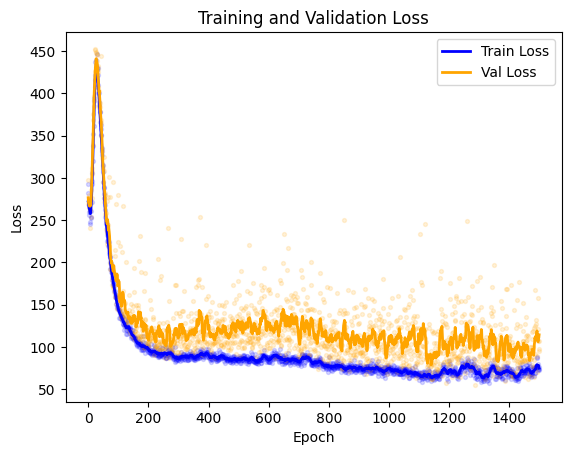

In [10]:
import matplotlib.pyplot as plt

train_loss = model.metrics[['epoch', 'epoch_train_loss']].dropna().reset_index(drop=True)
val_loss = model.metrics[['epoch', 'epoch_validation_loss']].dropna().reset_index(drop=True)

# Plot raw values as scatter points
plt.scatter(train_loss['epoch'], train_loss['epoch_train_loss'], color='blue', s=8, alpha=0.15)
plt.scatter(val_loss['epoch'], val_loss['epoch_validation_loss'], color='orange', s=8, alpha=0.15)

# Compute moving averages
train_loss_ma = train_loss['epoch_train_loss'].rolling(window=10, min_periods=1, center=True).mean()
val_loss_ma = val_loss['epoch_validation_loss'].rolling(window=10, min_periods=1, center=True).mean()

# Plot moving averages as lines
plt.plot(train_loss['epoch'], train_loss_ma, color='blue', linewidth=2, label='Train Loss')
plt.plot(val_loss['epoch'], val_loss_ma, color='orange', linewidth=2, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Project the learned dynamics onto the original input data

In [11]:
model.drift()

scDiffEq [INFO]: Added: adata.obsm['X_drift']
scDiffEq [INFO]: Added: adata.obsm['drift']


In [12]:
model.diffusion()

scDiffEq [INFO]: Added: adata.obsm['X_diffusion']
scDiffEq [INFO]: Added: adata.obsm['diffusion']


## Make a stream plot

Let's take a qualitative peek at the learned velocity. Here, we plot the learned drift function (the 2x512 fully-connected network) as the the vectory field. While we sample the diffusion field and plot the magnitude of diffusion and denote this using the colormap.

First, we need to make the velocity graph - this is mostly borrowed from the `scvelo` implementation.

In [13]:
sdq.tl.velocity_graph(model.adata)

scDiffEq [INFO]: Added: adata.obsp['distances']
scDiffEq [INFO]: Added: adata.obsp['connectivities']
scDiffEq [INFO]: Added: adata.uns['neighbors']
scDiffEq [INFO]: Added: adata.obsp['velocity_graph']
scDiffEq [INFO]: Added: adata.obsp['velocity_graph_neg']


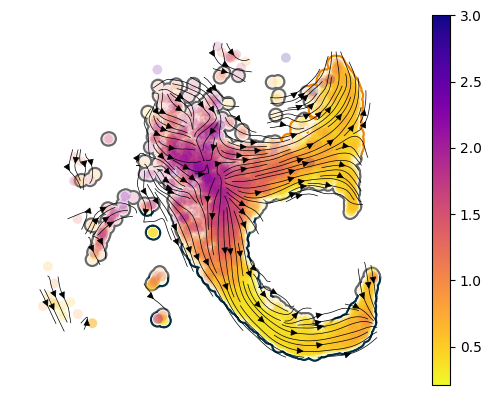

In [16]:
import cellplots

cmap = {
    "Undifferentiated": "dimgrey", #"#f0efeb",
    "Neutrophil": "#023047",
    "Monocyte": "#F08700",
}

axes = cellplots.umap_manifold(model.adata, groupby="Cell type annotation", c_background=cmap)
sdq.pl.velocity_stream(model.adata, c = "diffusion", ax=axes[0], scatter_kwargs={"vmax": 3})

## Sample and visualize trajectories

We can generatively simulate trajectories from the original dataset and study them furhter to take on a granular view of the developmental dynamics. Here, we'll use `dt=0.1d`. The LARRY dataset provides measurements at multiple time points, allowing us to interpolate and extrapolate developmental trajectories with high temporal resolution.

### Isolate some early progenitor cells and sample a few to start from

In [17]:
progenitor = (
    model.adata.obs.loc[model.adata.obs["Time point"] == model.adata.obs["Time point"].min()]
    .loc[model.adata.obs["Cell type annotation"] == "Undifferentiated"]
    .sample(3)
)
progenitor

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clone_idx,fate_observed,...,ct_score,ct_pseudotime,ct_num_exp_genes,nm_clones,W,test,fit_train,fit_val,drift,diffusion
2390,d2_2,TGCTTGGG-GGTCCCTT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,256.944,424.535,3801.0,True,...,0.0474299712113319,0.952570,236,True,1,False,True,False,26.022032,1.925547
2334,d2_3,AATAAGGA-GAAGCACT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,303.865,313.636,2693.0,True,...,0.068739448002275,0.931261,320,True,1,False,True,True,37.883366,1.771815
4974,LSK_d2_1,GTCTTCCT-GCGCATTC,2.0,Lin-Kit+Sca1+,Undifferentiated,0,470.467,464.074,3560.0,True,...,0.0636405458432328,0.936359,179,True,1,False,False,False,31.065161,1.441383


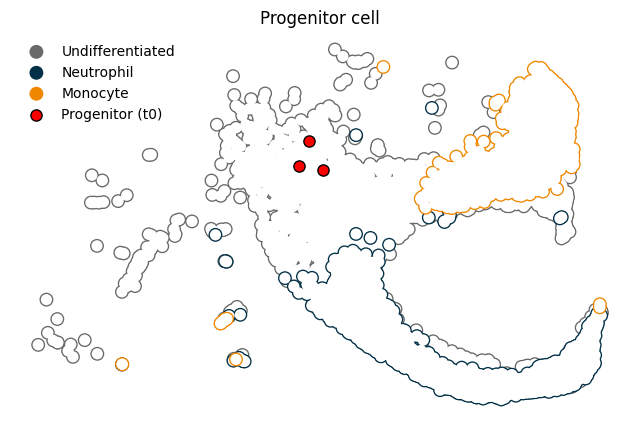

In [18]:
grouped = model.adata.obs.groupby("Cell type annotation")
x0 = model.adata[progenitor.index].obsm["X_umap"].toarray()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for group in ["Undifferentiated", "Neutrophil", "Monocyte"]:
    group_ix = grouped.get_group(group).index
    xu = model.adata[group_ix].obsm["X_umap"]
    ax.scatter(xu[:, 0], xu[:, 1], c=cmap[group], label=group, ec = "None", rasterized=True, s = 100)
    ax.scatter(xu[:, 0], xu[:, 1], c="white", ec = "None", rasterized=True, s = 65)
ax.scatter(x0[:, 0], x0[:, 1], c="r", s=65, ec="k", label = "Progenitor (t0)")
ax.legend(facecolor="None", edgecolor="None")
ax.set_title("Progenitor cell")
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

In [19]:
adata_sim = sdq.tl.simulate(
    adata, idx=progenitor.index, N=512, diffeq=model.DiffEq, time_key="Time point"
)
print(adata_sim)

AnnData object with n_obs × n_vars = 62976 × 50
    obs: 't', 'z0_idx', 'sim_i', 'sim'
    uns: 'sim_idx', 'simulated'


In [20]:
sdq.tl.annotate_cell_state(adata_sim, kNN=model.kNN, obs_key="Cell type annotation")

scDiffEq [INFO]: Bulding Annoy kNN Graph on adata.obsm['train']
scDiffEq [INFO]: Added state annotation: adata_sim.obs['Cell type annotation']


In [21]:
sdq.tl.annotate_cell_fate(adata_sim, state_key="Cell type annotation")

scDiffEq [INFO]: Added fate annotation: adata_sim.obs['fate']
scDiffEq [INFO]: Added fate counts: adata_sim.uns['fate_counts']


In [22]:
adata_sim.uns["fate_counts"]

{'Neutrophil': 1080, 'Monocyte': 318, 'Undifferentiated': 138}

Fit `UMAP` model to the training data

We can use `adata_sim.X` because our predictions (which are stored in `.X`) were made in the PCA space.

In [23]:
adata_sim.obsm["X_umap"] = UMAP.transform(adata_sim.X)

In [24]:
def plot_background(adata, ax):
    grouped = adata.obs.groupby("Cell type annotation")
    for group in ["Undifferentiated", "Neutrophil", "Monocyte"]:
        group_ix = grouped.get_group(group).index
        xu = model.adata[group_ix].obsm["X_umap"]
        ax.scatter(xu[:, 0], xu[:, 1], c=cmap[group], label=group, ec = "None", rasterized=True, s = 100)
        ax.scatter(xu[:, 0], xu[:, 1], c="white", ec = "None", rasterized=True, s = 65)
    ax.scatter(x0[:, 0], x0[:, 1], c="r", s=65, ec="k", label = "Progenitor (t0)")
    ax.legend(facecolor="None", edgecolor="None")


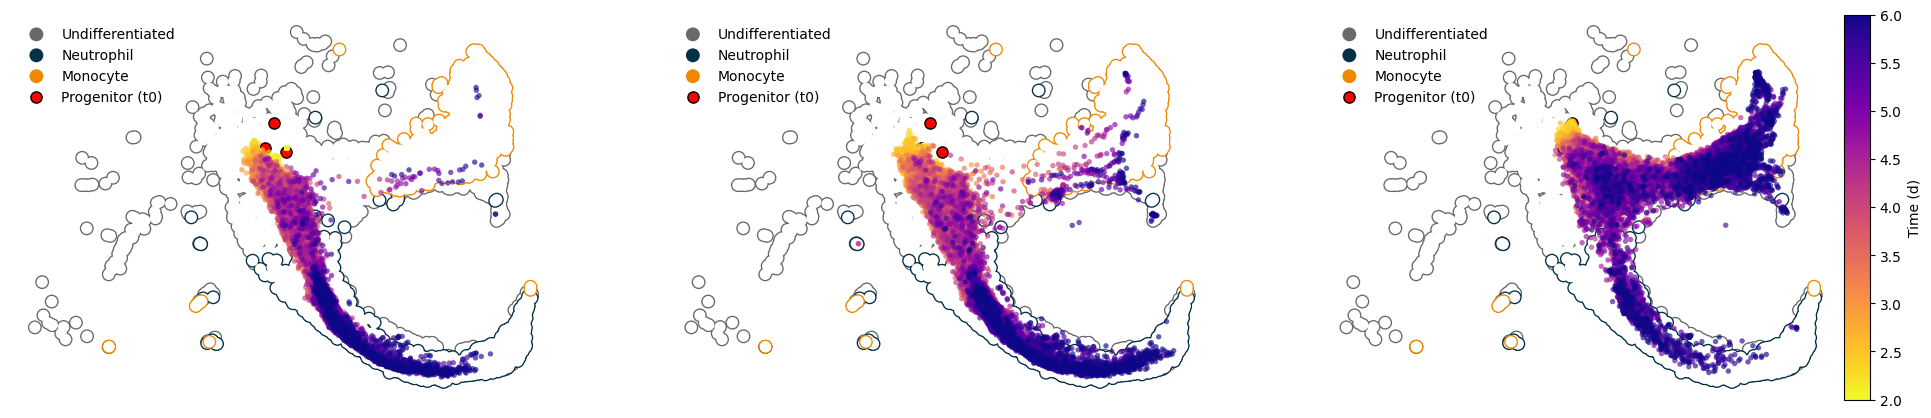

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))


for en, (progenitor, group_df) in enumerate(adata_sim.obs.groupby("z0_idx")):
    ax = axes[en]
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    plot_background(adata, ax)

    fate_subset = adata_sim[group_df.index]
    img = cellplots.umap(fate_subset, ax=ax, c=fate_subset.obs["t"], s=15, alpha=0.65, ec="None", cmap="plasma_r")

import numpy as np
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.min(adata_sim.obs["t"]), vmax=np.max(adata_sim.obs["t"])), cmap="plasma_r")
sm.set_array([])
plt.colorbar(sm, cax=cax, label="Time (d)")

## Gene-level analyses

In [ ]:
scaler_model = sdq.io.read_pickle("/Users/mvinyard/data/scdiffeq_data/larry/scaler.pkl")
PCA = sdq.io.read_pickle("/Users/mvinyard/data/scdiffeq_data/larry/pca.pkl")

In [ ]:
sdq.tl.annotate_gene_features(adata_sim, adata, PCA=PCA, gene_id_key="gene_ids")
sdq.tl.invert_scaled_gex(adata_sim, scaler_model = scaler_model)

scDiffEq [INFO]: Gene names added to: `adata_sim.uns['gene_ids']`
scDiffEq [INFO]: Inverted expression added to: `adata_sim.obsm['X_gene']`


In [ ]:
adata_sim.uns['sim_idx'] = list(adata_sim.uns['sim_idx'])
adata_sim.uns["gene_ids"] = adata_sim.uns["gene_ids"].to_dict()

adata_sim.write_h5ad("./adata_sim.larry.h5ad")
print(adata_sim)

AnnData object with n_obs × n_vars = 62976 × 50
    obs: 't', 'z0_idx', 'sim_i', 'sim', 'Cell type annotation', 'fate'
    uns: 'sim_idx', 'simulated', 'fate_counts', 'gene_ids'
    obsm: 'X_umap', 'X_gene', 'X_gene_inv'


In [ ]:
import pandas as pd

def mean_and_std_expr(df, adata_sim, gene):
    x = adata_sim[df.index].obsm["X_gene_inv"][gene]
    return pd.Series({'mean': x.mean(), 'std': x.std()})

In [ ]:
genes = ["Gfi1", "Elane", "Mpo", "Gstm1", "Mmp8", "Gata2"]

means = []
stds = []
for gene in genes:
    res = adata_sim.obs.groupby(["t", "fate"]).apply(mean_and_std_expr, adata_sim=adata_sim, gene=gene)
    mean_df = res['mean'].unstack()
    std_df = res['std'].unstack()
    means.append(mean_df)
    stds.append(std_df)

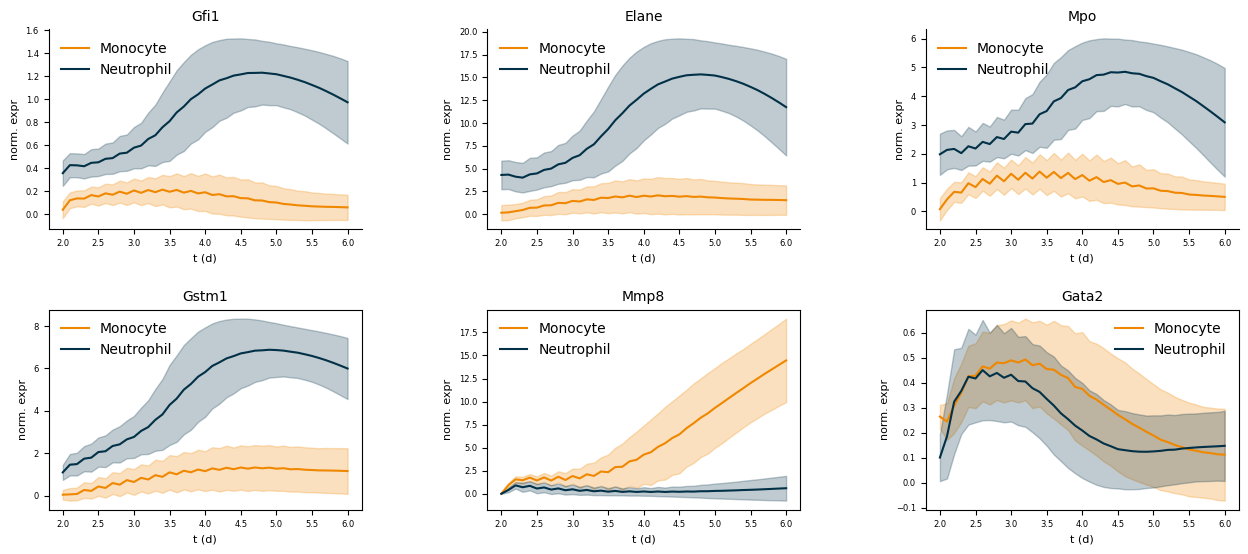

In [ ]:
fig, axes = cellplots.plot(
    6,
    3,
    height=0.65,
    width=0.8,
    wspace=0.4,
    hspace=0.4,
    x_label=["t (d)"],
    y_label=["norm. expr"],
    title=genes,
    delete=[["top", "right"]] * 3,
)

for en, (mean_df, std_df) in enumerate(zip(means, stds)):
    for col in mean_df:
        if col != "Undifferentiated":
            color = cmap[col]
            # Plot mean with line
            axes[en].plot(mean_df.index, mean_df[col], label=col, c=color)
            lower = mean_df[col] - std_df[col]
            upper = mean_df[col] + std_df[col]
            axes[en].fill_between(
                mean_df.index,
                lower,
                upper,
                color=color,
                alpha=0.25
            )
    axes[en].legend(facecolor="None", edgecolor="None")